<h2 style='color:blue' align='center'>Transfer learning in image classification</h2>

**In this notebook we will use transfer learning and take pre-trained model from google's Tensorflow Hub and re-train that on flowers dataset. Using pre-trained model saves lot of time and computational budget for new classification problem at hand**

In [2]:
pip install tensorflow tensorflow-hub


In [3]:
import numpy as np
import cv2
import PIL as PIL
import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

**Make predictions using ready made model (without any training)**

In [31]:
from google.colab import files
from PIL import Image
import io

uploaded = files.upload()

IMAGE_SHAPE = (224, 224)

for filename in uploaded.keys():

    gold_fish = Image.open(io.BytesIO(uploaded[filename])).resize(IMAGE_SHAPE)

    gold_fish.show()


Saving goldfish.jpg to goldfish (1).jpg


In [33]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: hub.KerasLayer("https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/5",
                                                    trainable=False)(x),
                           input_shape=IMAGE_SHAPE+(3,))
])

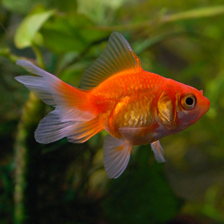

In [34]:
gold_fish = Image.open("goldfish.jpg").resize(IMAGE_SHAPE)
gold_fish

In [35]:
gold_fish = np.array(gold_fish)/255.0
gold_fish.shape

(224, 224, 3)

In [36]:
gold_fish[np.newaxis, ...]

array([[[[0.28235294, 0.33333333, 0.07058824],
         [0.31372549, 0.37254902, 0.09019608],
         [0.34901961, 0.41960784, 0.11764706],
         ...,
         [0.32941176, 0.39215686, 0.00392157],
         [0.32156863, 0.38431373, 0.00392157],
         [0.30980392, 0.36862745, 0.        ]],

        [[0.28627451, 0.33333333, 0.08235294],
         [0.3254902 , 0.38039216, 0.10980392],
         [0.35294118, 0.42352941, 0.12941176],
         ...,
         [0.32156863, 0.38039216, 0.00392157],
         [0.31372549, 0.37254902, 0.00392157],
         [0.30196078, 0.36078431, 0.        ]],

        [[0.28627451, 0.33333333, 0.08627451],
         [0.31372549, 0.36862745, 0.10196078],
         [0.34509804, 0.41568627, 0.12941176],
         ...,
         [0.31764706, 0.37647059, 0.00392157],
         [0.30980392, 0.36862745, 0.00784314],
         [0.29803922, 0.35686275, 0.00392157]],

        ...,

        [[0.05490196, 0.10980392, 0.01568627],
         [0.05098039, 0.11372549, 0.01960784]

In [37]:
temp=gold_fish[np.newaxis, ...]

In [38]:
temp.shape

(1, 224, 224, 3)

In [39]:
result = classifier.predict(gold_fish[np.newaxis, ...])
result.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


(1, 1001)

In [40]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [42]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving ImageNetLabels.txt to ImageNetLabels.txt
User uploaded file "ImageNetLabels.txt" with length 10484 bytes


In [43]:
# tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

In [44]:
image_labels[predicted_label_index]

'goldfish'

<h3 style='color:purple'>Load flowers dataset</h3>

In [45]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)
# cache_dir indicates where to download data. I specified . which means current directory
# untar true will unzip it

228813984/228813984 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [46]:
data_dir

'./datasets/flower_photos'

In [47]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

PosixPath('datasets/flower_photos')

In [48]:
list(data_dir.glob('*/*.jpg'))[:5]

[PosixPath('datasets/flower_photos/roses/16157873719_bf0bdf8558_n.jpg'),
 PosixPath('datasets/flower_photos/roses/5172171681_5934378f08.jpg'),
 PosixPath('datasets/flower_photos/roses/1666341535_99c6f7509f_n.jpg'),
 PosixPath('datasets/flower_photos/roses/22385375599_1faf334f5d_n.jpg'),
 PosixPath('datasets/flower_photos/roses/9458445402_79e4dfa89c.jpg')]

In [49]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [50]:
roses = list(data_dir.glob('roses/*'))
roses[:5]

[PosixPath('datasets/flower_photos/roses/16157873719_bf0bdf8558_n.jpg'),
 PosixPath('datasets/flower_photos/roses/5172171681_5934378f08.jpg'),
 PosixPath('datasets/flower_photos/roses/1666341535_99c6f7509f_n.jpg'),
 PosixPath('datasets/flower_photos/roses/22385375599_1faf334f5d_n.jpg'),
 PosixPath('datasets/flower_photos/roses/9458445402_79e4dfa89c.jpg')]

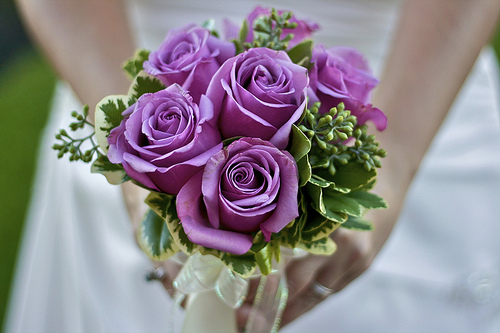

In [51]:
PIL.Image.open(str(roses[1]))

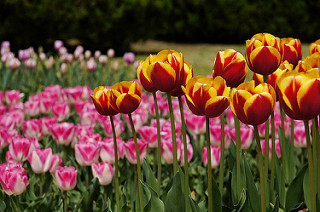

In [52]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

<h3 style='color:purple'>Read flowers images from disk into numpy array using opencv</h3>

In [53]:
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [54]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

In [55]:
flowers_images_dict['roses'][:5]

[PosixPath('datasets/flower_photos/roses/16157873719_bf0bdf8558_n.jpg'),
 PosixPath('datasets/flower_photos/roses/5172171681_5934378f08.jpg'),
 PosixPath('datasets/flower_photos/roses/1666341535_99c6f7509f_n.jpg'),
 PosixPath('datasets/flower_photos/roses/22385375599_1faf334f5d_n.jpg'),
 PosixPath('datasets/flower_photos/roses/9458445402_79e4dfa89c.jpg')]

In [56]:
str(flowers_images_dict['roses'][0])

'datasets/flower_photos/roses/16157873719_bf0bdf8558_n.jpg'

In [57]:
img = cv2.imread(str(flowers_images_dict['roses'][0]))

In [58]:
img.shape

(213, 320, 3)

In [59]:
cv2.resize(img,(224,224)).shape

(224, 224, 3)

In [60]:
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [61]:
X = np.array(X)
y = np.array(y)

<h3 style='color:purple'>Train test split</h3>

In [62]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

<h3 style='color:purple'>Preprocessing: scale images</h3>

In [63]:
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

**Make prediction using pre-trained model on new flowers dataset**

In [64]:
X[0].shape

(224, 224, 3)

In [65]:
IMAGE_SHAPE+(3,)

(224, 224, 3)

In [66]:
x0_resized = cv2.resize(X[0], IMAGE_SHAPE)
x1_resized = cv2.resize(X[1], IMAGE_SHAPE)
x2_resized = cv2.resize(X[2], IMAGE_SHAPE)

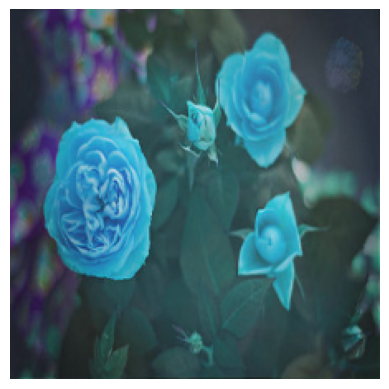

In [67]:
plt.axis('off')
plt.imshow(X[0])

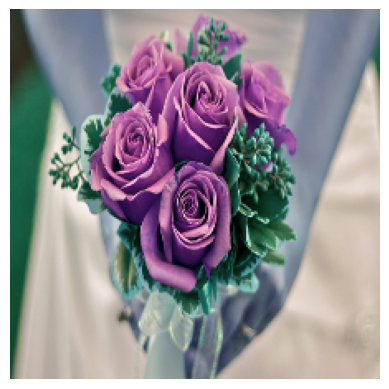

In [68]:
plt.axis('off')
plt.imshow(X[1])

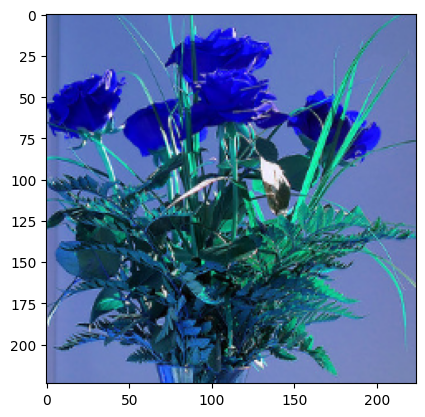

In [69]:

plt.imshow(X[2])

In [70]:
predicted = classifier.predict(np.array([x0_resized, x1_resized, x2_resized]))
predicted = np.argmax(predicted, axis=1)
predicted

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([795, 795, 795])

In [71]:
image_labels[795]

'shower curtain'

<h3 style='color:purple'>Now take pre-trained model and retrain it using flowers images</h3>

In [72]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [74]:
import tensorflow as tf

num_of_flowers = 5

model = tf.keras.Sequential([
    tf.keras.layers.Lambda(lambda x: pretrained_model_without_top_layer(x)),
    tf.keras.layers.Dense(num_of_flowers, activation='softmax')
])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lambda_2 (Lambda)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [75]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


86/86 ━━━━━━━━━━━━━━━━━━━━ 105s 1s/step - acc: 0.5539 - loss: 1.1562
Epoch 2/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - acc: 0.8663 - loss: 0.4237
Epoch 3/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 99s 1s/step - acc: 0.8964 - loss: 0.3351
Epoch 4/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 141s 1s/step - acc: 0.9178 - loss: 0.2716
Epoch 5/5
86/86 ━━━━━━━━━━━━━━━━━━━━ 96s 1s/step - acc: 0.9342 - loss: 0.2449


In [76]:
model.evaluate(X_test_scaled,y_test)

29/29 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - acc: 0.8658 - loss: 0.3790


[0.3774133622646332, 0.8605664372444153]

In [77]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Normalize to [0, 1] range
    return img_array

In [79]:
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving sun.jpg to sun.jpg
User uploaded file "sun.jpg" with length 65526 bytes


In [80]:
test_image_path = 'sun.jpg'
test_image = preprocess_image(test_image_path)
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions, axis=1)

print(f"Predicted class: {predicted_class}")

# Example class names (should match your dataset structure)
class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']
print(f"Predicted flower: {class_names[predicted_class[0]]}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 677ms/step
Predicted class: [3]
Predicted flower: sunflowers
